## 0. Summary

This notebook investigates the compression of the volatility risk premium (VRP) in the S&P 500 options market.

The volatility risk premium — the difference between implied and realized volatility — has historically provided a reliable return source to investors willing to take the other side of hedging demand. However, as systematic short-volatility strategies have grown in popularity and scale, this premium may have diminished.

In this project, I:

- Collected and cleaned SPX option data with quote-level granularity
- Calculated implied volatilities using a custom Black-Scholes implementation with a Newton-Raphson + bisection implementation
- Computed 21-day forward realized volatility from SPX returns
- Constructed a panel of implied vs. realized volatility across time
- Aggregated IV by midprice-weighted average for each quote date
- Analyzed VRP dynamics and visualized signs of structural compression

The results show that while the VRP remains generally positive, a trend of compression is observable, particularly after 2012 — coinciding with the rise of passive investing and volatility-targeting strategies. This may have implications for the sustainability of short-volatility premia going forward.


## 1. Introduction

### 1.1 Implied Volatility

__Implied Volatility__ (IV) reflects the market’s expectation of how volatile an asset might be in the future. It is not observed directly but is inferred from the prices of put and call options.
IV is the volatility input that makes the model price equal to the actual market price of the option, given the current price of the underlying asset and other known parameters.
Importantly, IV doesn't predict actual future __Realized Volatility__ perfectly — it also includes a premium investors are willing to pay or receive for uncertainty and risk.

### 1.2 The Volatility Risk Premium

The difference between IV and Realized Volatility is called __Volatility Risk Premium__ (VRP). For the buyer, it can be understood as the price of insurance against market movements, for the seller it is the premium collected for taking on the risk of potentially extreme market movements. IV as implied by option contract prices is most often considerably higher than historical volatility, the opportunity to earn a systemic risk premium exists in [theorie and in practice](https://quantpedia.com/strategies/volatility-risk-premium-effect).

#### The Rise in Volatility Risk Harvesting
The profitability of systematically betting against high volatility has led to the widespread adoption of such strategies across the investment industry. Bhansali and Harris (2021) estimated that approximately [$1.5 trillion in assets](https://www.trendfollowing.com/pdfs/short_volatility.pdf   ) are managed by investors whose strategies result in either explicit or implicit short volatility exposure. "Low-levels of implied volatility make low levels of implied volatility appear reasonable and allow managers to justify selling volatility a low prices. \[...\] Low realized volatility also makes long volatility positions less attractive for delta-hedgers who might otherwise offset volatility selling." This is our starting point.

### 1.3 Hypothesis: Crowding, Compression, and Mispricing

As the VRP became a well-known and historically profitable source of return, an increasing number of institutional investors began deploying __systematic short-volatility strategies__. These are often __rule-based and price-agnostic__: they sell volatility based on fixed criteria like moneyness thresholds (e.g., 20% OTM), fixed DTE (e.g., 30 days), or delta bands (e.g., selling 10-delta options), rather than based on an assessment of whether IV offers sufficient compensation for risk.

This systemic selling has turned the SPX options market into a __supply-dominated environment__, where persistent offer pressure forces implied volatility lower — even when realized volatility may not be similarly falling.

This leads to two important structural effects:
1. __Implied Volatility becomes endogenous__: It no longer solely reflects exogenous uncertainty about future returns, but also the mechanical effects of supply from volatility sellers.
2. __The VRP compresses__: If realized volatility is relatively stable but IV falls due to over-supply, the spread between them shrinks. 

#### Central Hypothesis

> __The systemic crowding into short-volatility strategies has led to structural compression of the volatility risk premium in SPX options.__

This motivates the following empirical question:
- Has the VRP compressed in a statistically and economically significant way over the past decade?

## 2. Context: Betting on Low Volatility, "Volmageddon" and Rebound

The post-2008 low volatility environment gave room to the growth of inverse VIX exchange-traded products (ETPs). In late 2010, Credit Suisse launched the first popular ETN shorting VIX futures, the VelocityShares Daily Inverse VIX ETN (ticker XIV). Early investments were in the tens of millions, but as volatility remained low and inverting the VIX delivered high returns, volume grew drastically.

By 2013, researchers had identified around 50 volatility-linked ETPs (long and short) globally with roughly [\\$3 billion total AUM](https://www.amf-france.org/sites/institutionnel/files/contenu_simple/lettre_ou_cahier/risques_tendances/Heightened%20volatility%20in%20early%20February%202018%20the%20impact%20of%20VIX%20products.pdf#:~:text=In%20all%2C%20in%202013%2C%20Alexandre,point%20on%2023%20March%202018), about half in short positions.

This growth accelerated into 2017, one of the least volatile years on record. By the end of 2017, the four largest inverse VIX products (led by XIV and SVXY) together reached about [\\$2.6 billion in AUM](https://www.amf-france.org/sites/institutionnel/files/contenu_simple/lettre_ou_cahier/risques_tendances/Heightened%20volatility%20in%20early%20February%202018%20the%20impact%20of%20VIX%20products.pdf#:~:text=In%20all%2C%20in%202013%2C%20Alexandre,point%20on%2023%20March%202018).

(For context, these products track indexes of short-term VIX futures, essentially betting that the VIX will not spike significantly.) [Investors were attracted by stellar returns](https://caia.org/sites/default/files/in_free_fall_and_yet_attractive_short_volatility_etfs.pdf#:~:text=In%20the%20twelve%20days%20between,On%20the%20two%20business) – from 2012 to 2017, XIV had cumulative gains of over +1,700%, vastly outperforming the S&P 500 (which gained ~120% in that period).

The incentive of steady income from shorting overpriced insurance (volatility) led not only retail traders but also institutional money to pile into short-volatility trades.

__Hedge funds and alternatives:__ The short-volatility boom was not limited to ETPs. Hedge funds and alternative mutual funds also embraced option-writing (selling of options) and volatility-selling strategies. For example, the LJM Preservation & Growth Fund (LJMIX), a mutual fund selling S&P 500 options, grew from [\\$450 million to \\$768 million in assets](https://www.slcg.com/resources/blog/685#:~:text=Investors%20Strangled%20by%20LJM%20Preservation,2017%20option%20portfolio%20to) between 2015 and late 2017.

Overall, by late 2017, the International Monetary Fund (IMF) warned that roughly [\\$500 billion was tied up in strategies implicitly short volatility](https://www.bahamastradeinfo.gov.bs/sector-news/imf-warns-volatility-products-loom-as-next-big-market-shock/#:~:text=30%20Oct%202017) — a sixfold increase from the start of the decade.

In short, betting against volatility had evolved from a niche trade into a crowded strategy by 2017.

### The 2018 Volatility Spike - "Volmageddon"

On February 5, 2018, the VIX surged over 100% in a single day, triggering the collapse of major inverse volatility ETPs like XIV and causing SVXY to lose over [90% of its value overnight](https://sixfigureinvesting.com/2018/02/what-happened-to-xiv-and-svxy/). At its peak in January 2018, XIV alone had over [\\$1.9B in AUM, and total short-vol ETP assets exceeded \\$3.7B](https://www.amf-france.org/sites/default/files/private/2018-12/risk-and-trends-2018.pdf). After the crash, assets dropped below \\$1B in a matter of days. The episode highlighted the risks of crowded short-volatility positioning and remains a [key event in volatility markets literature](https://www.reuters.com/article/us-usa-funds-ljm-idUSKCN1GD5I4).

### Rebound of the Low Volatility Trade

In the wake of the 2018 crash, the short-volatility ecosystem underwent major changes. Surviving products like [SVXY reduced their leverage](https://sixfigureinvesting.com/2018/02/what-happened-to-xiv-and-svxy/), shifting from –1× to –0.5× exposure to short-term VIX futures, in an effort to mitigate tail risk. With confidence shaken, total AUM in inverse volatility ETPs remained depressed through 2019, as many investors avoided re-entering the space.

However, as volatility normalized in the second half of 2019, assets slowly returned. The [March 2020 COVID-19 crash](https://www.bloomberg.com/news/articles/2020-03-16/volatility-surges-as-vix-hits-highest-since-2008-financial-crisis) — which sent the VIX briefly above 80 — marked another major test. This time, the newly de-levered SVXY declined sharply but survived, underscoring how structural changes helped reduce systemic vulnerability.

Beginning in 2021, a new generation of short-volatility products emerged. Simplify Asset Management launched the actively managed [SVOL ETF](https://www.simplify.us/etfs/svol), which combines short VIX futures exposure with long VIX calls to cap tail risk. SVOL quickly attracted interest due to its income-generation focus. In 2022, Barclays introduced [SVIX](https://www.barclaysipath.com/US/40/Detail.action?instrumentId=us4042807646), a new ETN offering –1× daily exposure to short-term VIX futures — essentially a reboot of the now-defunct XIV.

By early 2025, assets in short-volatility ETPs have rebounded significantly. [SVOL holds about \\$850 million](https://etfdb.com/etf/SVOL/), [SVIX around \\$740 million](https://ycharts.com/companies/SVIX), and [SVXY roughly \\$640 million](https://ycharts.com/companies/SVXY), bringing the combined total to __approximately \\$2.2 billion__. While still below the \\$3.7B peak of early 2018, this recovery reflects renewed demand, now tempered with structural safeguards and risk-aware positioning.

In parallel, several large volatility-selling strategies remain embedded in institutional portfolios. For example, [Gateway's S&P 500 covered call fund](https://www.gatewayfunds.com/) continues to manage multiple billions, relying on systematic option writing rather than outright short volatility bets. These more conservative strategies were less affected by prior volatility spikes and offer more stable, though lower, yield profiles.

The trajectory from 2010 through 2025 illustrates the arc of short-volatility investing: __meteoric growth__, a __sharp correction__, and a __cautious resurgence__.

This analysis does not aim to time volatility spikes but to evaluate whether the VRP has become structurally mispriced due to supply-side distortions. If true, it opens the door for systematic long-volatility strategies — not as tail-risk hedges, but as viable standalone strategies with positive expected returns under certain conditions.


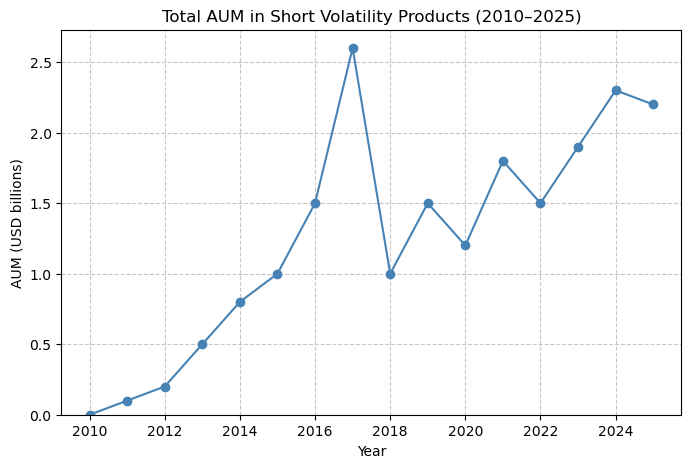

In [956]:
### Graph total AUM

import matplotlib.pyplot as plt

# Years and approximate total AUM (USD billions) in short-volatility products, values from cited sources and reasonably interpolated for missing years (2013, 2023)
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 
         2019, 2020, 2021, 2022, 2023, 2024, 2025]
aum = [0.0, 0.1, 0.2, 0.5, 0.8, 1.0, 1.5, 2.6, 1.0, 
       1.5, 1.2, 1.8, 1.5, 1.9, 2.3, 2.2]  # in USD billions

plt.figure(figsize=(8,5))
plt.plot(years, aum, marker='o', color='steelblue')
plt.title('Total AUM in Short Volatility Products (2010–2025)')
plt.xlabel('Year')
plt.ylabel('AUM (USD billions)')
plt.ylim(bottom=0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## 3. Focussing on 30 DTE options and the S&P 500

This analysis concentrates on SPX options with approximately 30 days to expiration (DTE), a maturity not choosen randomly, but driven by the main inspiration of this analysis in the first place.

In a 2020 episode of the _Flirting with Models_ podcast, Benn Eifert (QVR Advisors) described how many institutional investors systematically harvest the volatility risk premium using strategies such as __cash-secured put selling__ and __covered call writing__, focussing on the S&P 500. These strategies are typically __rule-based and executed monthly__, often aligned with the standard 30-day options expiration cycle.

Because these flows are __not discretionary but mechanically repeated__, they result in __persistent offer pressure__ on options near 30 DTE. This structural behavior influences implied volatility levels in a systematic way — creating the very environment where supply/demand imbalances may compress the volatility risk premium.

By focusing on this maturity, the analysis is better aligned with where __institutional VRP harvesting occurs in size__, and where crowding effects are most likely to cause in observable distortions between implied and realized volatility.

_Reference:_ [Flirting with Models, Season 3, Episode 3: Dr. Benn Eifert - Bad Ideas (S3E3)](https://open.spotify.com/episode/3xBRY2T6whzwmO4YXzgR37?si=5403ce4ee51b45a2)



## 4. Data Source and Preparation

We use EOD data on call and puts on the S&P500 for each trading day between 01.01.2010 and 31.12.2023 for different IV levels. The original data vendor is [optionsDX](https://www.optionsdx.com). The size of the original files made it necessary to use a MySQL database for cleaning and reorganization of the data. 

The extraction was performed using a Python script that queried the database via __SQLAlchemy__, selecting:

- All __call and put options__ with __days to expiration (DTE)__ between __28 and 32__ (to approximate a 30-day horizon, adjusting for non-trading days),
- Only rows with **non-zero and non-null bid and ask prices**,  
- Along with associated fields including `quote_date`, `expire_date`, `strike`, and `underlying_last`.

No other filters were applied yet — the dataset includes __all available contracts__ matching the DTE and quote criteria.  

Due to database security restrictions, the credentials and connection code are not included here. However, the final dataset was exported as a `.csv` file using the following SQL Query:
<details>
<summary>🔍 SQL Query </summary>

```sql
SELECT
    'call' AS option_type,
    ct.quote_date,
    ct.expire_date,
    ct.dte,
    ct.strike,
    ct.c_bid AS bid_price,
    ct.c_ask AS ask_price,
    m.underlying_last
FROM calls_table ct
JOIN metadata m ON ct.quote_date = m.quote_date
WHERE ct.dte BETWEEN 28 AND 32
  AND ct.c_bid IS NOT NULL AND ct.c_bid > 0
  AND ct.c_ask IS NOT NULL AND ct.c_ask > 0

UNION ALL

SELECT
    'put' AS option_type,
    pt.quote_date,
    pt.expire_date,
    pt.dte,
    pt.strike,
    pt.p_bid AS bid_price,
    pt.p_ask AS ask_price,
    m.underlying_last
FROM puts_table pt
JOIN metadata m ON pt.quote_date = m.quote_date
WHERE pt.dte BETWEEN 28 AND 32
  AND pt.p_bid IS NOT NULL AND pt.p_bid > 0
  AND pt.p_ask IS NOT NULL AND pt.p_ask > 0;

__Subsequently we use the midpoint of the spread between ask and bid as price of an option:__ 
$$
[\frac{\text{bid} + \text{ask}}{2}]
$$

In [45]:
import pandas as pd
df = pd.read_csv("dte30_options_export.csv", parse_dates=["quote_date", "expire_date"])
df.head(3)

,option_type,quote_date,expire_date,dte,strike,mid_price,underlying_last
0,call,2013-07-01,2013-08-02,32,1435.0,179.460,1614.86
1,call,2013-07-01,2013-08-02,32,1510.0,108.500,1614.86
2,call,2013-07-01,2013-08-02,32,1600.0,36.495,1614.86


This way, a unique option, which can always be identified by the unique pair of _expire_date_ and _strike_ may apear up to 5 times in this dataset, with _DTE_ values of {28,29,30,31,32}. Since we want to investigate options aligned with the standard 30-day options expiration cycle, we will drop duplicates and keep only one entry for each individual contract, with the DTE entry closest to 30. We prioritze the __earlier entry clostest to 30__ meaning __31>29__, because it is closer in lookahead time to 30 days.

In [571]:
### Filtering out duplicates 

# Add absolute distance from 30
df['dte_diff'] = (df['dte'] - 30).abs()

# Add negative DTE to prefer higher DTE when tied (e.g. prefer 31 over 29)
df['neg_dte'] = -df['dte']

# Sort for best match per contract
df_sorted = df.sort_values(by=['option_type', 'strike', 'expire_date', 'dte_diff', 'neg_dte'])

# Keep only best fitting quote per contract
df_unique = df_sorted.drop_duplicates(subset=['option_type', 'strike', 'expire_date'], keep='first')

# Drop helper columns
df_unique = df_unique.drop(columns=['dte_diff', 'neg_dte'])

print(f" Unique contracts: {len(df_unique)}")

 Unique contracts: 256576


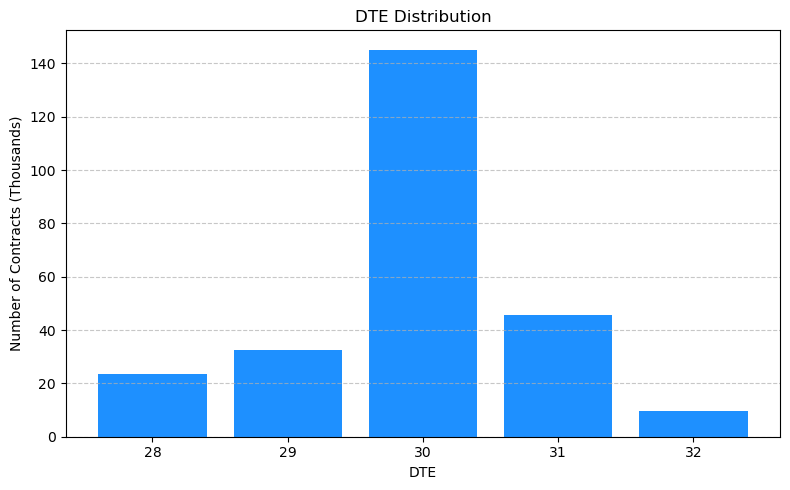

In [962]:
### Graph

# Count and scale
dte_counts = df_unique['dte'].value_counts().sort_index()
dte_counts_k = dte_counts / 1000  # convert to thousands

# Plot
plt.figure(figsize=(8, 5))
plt.bar(dte_counts_k.index, dte_counts_k.values, color="dodgerblue")
plt.xlabel("DTE")
plt.ylabel("Number of Contracts (Thousands)")
plt.title("DTE Distribution")
plt.xticks(dte_counts_k.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 5. Data Enrichment for Implied Volatility Calculation

To calculate implied volatility for each option contract, we enrich the dataset with two additional inputs, matched to the option’s quote date:

- The __risk-free rate__, approximated by the U.S. 10-Year Treasury yield, available as a daily time series from FRED. This serves as a standard proxy for the time value of money.
- The __annualized dividend yield of the S&P 500__, which is not directly available in index-level data.

To estimate the dividend yield, we use the SPY ETF as a proxy. SPY closely tracks the S&P 500 but includes dividend distributions through its adjusted closing prices. By comparing SPY’s total return (adjusted close) to the S&P 500 price return, we obtain a market-implied estimate of the effective dividend income received by index investors.

Because dividends are paid irregularly and can cause large one-day return jumps (e.g., on ex-dividend dates), the raw daily yield estimate is too noisy to be used directly in modeling. Instead, we apply a __30-day rolling average__ to the daily yield to smooth out these spikes and obtain a more stable estimate.

This smoothed daily yield is then __annualized using the standard convention__:

$$
q_{\text{annual}} = \text{RollingAvg}_{\text{daily}} \times 252
$$

where $q_{\text{annual}}$ is the annualized dividend yield and 252 is the assumed number of trading days in a year.

By using this annualized yield, we ensure consistency with other model inputs and maintain robustness across time periods, including those affected by dividend timing anomalies or market disruptions.


#### Merging Inputs into the Options Dataset

To incorporate the calculated dividend yield and risk-free rate into each option contract, we perform a date-based merge:

- The __annualized dividend yield__ (from the rolling SPY–S&P 500 return difference) is merged on the option’s `quote_date`.
- The __risk-free rate__ is sourced from the U.S. 10-Year Treasury yield (GS10) from FRED and also merged on `quote_date`. The rate is reported in percent and converted to decimal form:
  
$$
r = \frac{\text{GS10}}{100}
$$

Since the GS10 data is available at monthly frequency, we forward-fill the latest value to cover all trading dates in the options dataset. This ensures that each contract is matched with a consistent macro input, even when no rate is reported on the exact date.

The merged dataset now contains, for each contract:
- The option’s midquote, strike, and maturity information,
- The __annualized dividend yield__ estimate on the quote date,
- The corresponding __risk-free rate__.

__Important Note:__ The annualized yield dividend is based on a 30-day rolling average. This means that this value is not defined for the first 30 days of our dataset. Therefore we will drop the first 30 trading days, which equals dropping 3,777 contracts. Our first valid is day for analysis is now __17.02.2010__.

Using this structure we have all inputs necessary to compute Implied Volatility using the well known __Black-Scholes Model__.


In [451]:
### Enriching dataset

# Unique option contracts are in df_unique, already loaded

# Load annualized dividend yield data
df_div = pd.read_csv("enriched_dividend_yield_2010_2023.csv", parse_dates=["Date"])
df_div.set_index("Date", inplace=True)

# Load and prepare risk-free rate data (GS10 from FRED)
df_rf = pd.read_csv("GS10.csv", parse_dates=["observation_date"])
df_rf.rename(columns={"observation_date": "quote_date", "GS10": "risk_free_rate"}, inplace=True)
df_rf["risk_free_rate"] = pd.to_numeric(df_rf["risk_free_rate"], errors="coerce") / 100  # % → decimal

# Reindex to daily frequency and forward-fill
df_rf = df_rf.set_index("quote_date").asfreq("D").ffill().reset_index()

# Merge dividend yield on quote_date
df_merged = pd.merge(df_unique, df_div, how="left", left_on="quote_date", right_index=True)

# Merge daily forward-filled risk-free rate on quote_date
df_merged = pd.merge(df_merged, df_rf, how="left", on="quote_date")

# Final check
df_merged.head(3)



,option_type,quote_date,expire_date,dte,strike,mid_price,underlying_last,SP500_Close,SP500_Return,SPY_Adj_Close,SPY_Return,Daily_Dividend_Yield,RollingAvg_Daily_Yield,Annualized_Dividend_Yield,risk_free_rate
0,call,2011-08-16,2011-09-15,30,100.0,1089.795,1192.50,1192.760010,-0.009739,93.143112,-0.008539,0.001199,0.000074,0.018535,0.0230
1,call,2012-01-17,2012-02-16,30,100.0,1190.550,1293.56,1293.670044,0.003553,101.900330,0.003881,0.000328,0.000068,0.017217,0.0197
2,call,2013-02-12,2013-03-14,30,100.0,1415.140,1519.59,1519.430054,0.001595,122.424583,0.001648,0.000053,0.000068,0.017029,0.0198


In the next step we will drop columns not needed for further analysis and the first 30, unusable days of contracts where the rolling annualized yield is undefined. 

In [449]:
### Dropping not needed data

# Derive is_call from option_type
df_merged["is_call"] = df_merged["option_type"].str.upper() == "C"

# Convert DTE to annualized time to maturity
df_merged["time_to_maturity"] = df_merged["dte"] / 365

# Select relevant columns for Black-Scholes IV calculation
df_analysis = df_merged[[
    "quote_date",
    "expire_date",
    "underlying_last",
    "strike",
    "mid_price",
    "is_call",
    "risk_free_rate",
    "Annualized_Dividend_Yield",
    "time_to_maturity"
]].dropna(subset=["Annualized_Dividend_Yield"]).copy()

# Preview the final dataset
df_analysis.info()
df_analysis.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 256218 entries, 0 to 256575
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   quote_date                 256218 non-null  datetime64[ns]
 1   expire_date                256218 non-null  datetime64[ns]
 2   underlying_last            256218 non-null  float64       
 3   strike                     256218 non-null  float64       
 4   mid_price                  256218 non-null  float64       
 5   is_call                    256218 non-null  bool          
 6   risk_free_rate             256218 non-null  float64       
 7   Annualized_Dividend_Yield  256218 non-null  float64       
 8   time_to_maturity           256218 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6)
memory usage: 17.8 MB


,quote_date,expire_date,underlying_last,strike,mid_price,is_call,risk_free_rate,Annualized_Dividend_Yield,time_to_maturity
0,2011-08-16,2011-09-15,1192.50,100.0,1089.795,False,0.0230,0.018535,0.082192
1,2012-01-17,2012-02-16,1293.56,100.0,1190.550,False,0.0197,0.017217,0.082192
2,2013-02-12,2013-03-14,1519.59,100.0,1415.140,False,0.0198,0.017029,0.082192


## 6. The Black Scholes-Model

The Black-Scholes model was the first widely adopted mathematical framework for pricing European-style options. While the model's underlying assumptions — including frictionless markets, constant volatility, and lognormal price dynamics — are subject to critique, its practical effectiveness make it a foundational tool in modern quantitative finance. Its relative ease of use also makes it attractive for us.

In its classical application, the Black-Scholes model is used to compute the theoretical price of an option given all model inputs, including the volatility $\sigma$ of the underlying asset. In our context, however, the forward-looking volatility of the S&P 500 index is not known ex ante.

Instead, we observe the __market price of the option__, taken as the midpoint between bid and ask quotes, and invert the model to recover the implied value of $\sigma$ that rationalizes this market price under the Black-Scholes framework. This recovered value is referred to as the __IV__,the market’s consensus expectation of volatility over the remaining life of the option.

Although the derivation is omitted here, a formal treatment and discussion of the model’s limitations can be found [here](https://www.columbia.edu/~mh2078/FoundationsFE/BlackScholes.pdf). The resulting pricing formulas are given below.

#### Call Option Price

$$
C(S, t) = e^{-q(T - t)} S_t \, \Phi(d_1) - e^{-r(T - t)} K \, \Phi(d_2)
$$



#### Put Option Price

$$
P(S, t) = e^{-r(T - t)} K \, \Phi(-d_2) - e^{-q(T - t)} S_t \, \Phi(-d_1)
$$



#### Where:

$$
d_1 = \frac{\ln\left(\frac{S_t}{K}\right) + \left(r - q + \frac{1}{2} \sigma^2\right)(T - t)}{\sigma \sqrt{T - t}}, \quad
d_2 = d_1 - \sigma \sqrt{T - t}
$$



- $S_t$: Underlying index level at time $t$ → `underlying_last`
- $K$: Strike price → `Strike` 
- $T - t$: Time to maturity (in years) → `time_to_maturity`  
- $r$: Risk-free interest rate → `risk_free_rate` 
- $q$: Continuous dividend yield → `Annualized_Dividend_Yield`
- $P(S, t)$ &  $C(S, t)$: In our case the observed market price → `mid_price`
- $\Phi(\cdot)$: Standard normal cumulative distribution function of $d_1$ and $d_2$ → needs to be calculated
- $\sigma$: Volatility → Target variable 

### Implied Volatility as the Inverse of the Black-Scholes Formula

Given a market-observed option price $C_{\text{market}}$, we define the implied volatility as the value of $\sigma$ that equates it with the model price, solving the problem:
$$
\sigma_{\text{impl}} = \arg\min_{\sigma > 0} \left| C_{\text{BS}}(\sigma) - C_{\text{market}} \right|
$$

This inversion problem has __no closed-form solution__ and must be solved __numerically__, typically using iterative root-finding algorithms such as [Newton-Raphson](https://en.wikipedia.org/wiki/Newton%27s_method) or [bisection](https://en.wikipedia.org/wiki/Bisection_method). In practice, we supply an initial guess (e.g., $\sigma_0 = 0.2$) and refine it until the difference between model price and market price is within an acceptable tolerance.

This process allows us to recover the market’s implied expectation of volatility embedded in the prices of traded options, conditional on the Black-Scholes framework.

## 7. Considerations for Practical Implementation

### 7.1 Newton-Raphson Method for Implied Volatility

The Newton-Raphson method is a fast and commonly used root-finding algorithm to estimate implied volatility. It uses both the value and the slope (first derivative with respect to $\sigma$, called __Vega__) of the Black-Scholes pricing function to iteratively improve an initial guess.

The update rule is given by:

$$
\sigma_{n+1} = \sigma_n - \frac{C_{\text{BS}}(\sigma_n) - C_{\text{market}}}{\text{Vega}(\sigma_n)}
$$

When the initial "guess" is close enough to the true solution and under regularity conditions (i.e., non-zero Vega), the method exhibits __quadratic convergence__. This means that the number of correct digits in the estimate roughly doubles with each iteration.

However, convergence is not guaranteed. Failures can occur when:

- __Vega is near zero__
    - Usually the Case for options very far ITM (__in-the-money__) or OTM (__out-the-money__) & close to expiry. This is because the price of options under these conditions are no longer senstive to changes in volatility, the prices instead match the intrinsic value of the contract and IV is close to zero.    
- __The initial guess is too far from the true IV__
    - Occurs with either poor initialiaztion or extremly missaligned option prices. Newton-Raphson assumes local linearity. If the guess is too far off, updates can overshoot, diverge, or produce negative values.
- __The market price is outside the theoretical bounds of the Black-Scholes model__
    - If the price is below intrinsic value or unrealistically high, no volatility satisfies the Black-Scholes equation. Newton-Raphson fails because no root exists.

#### Short Note on Vega

__Vega__ is a well-defined and commonly used [__Greek__](https://en.wikipedia.org/wiki/en:Greeks_(finance)?variant=zh-tw) in options pricing. It measures the __sensitivity of an option's price to changes in the implied volatility__ of the underlying asset. In other words, Vega tells us how much the price of an option will increase or decrease if volatility changes by 1 percentage point.

Formally, Vega is the partial derivative of the option price with respect to volatility:

$$
\text{Vega} = \frac{\partial C}{\partial \sigma}
$$

For European call and put options under the Black-Scholes model (with continuous dividend yield $q$), Vega is given by:

$$
\text{Vega} = S \cdot e^{-qT} \cdot \phi(d_1) \cdot \sqrt{T}
$$

Where:
- $S$: Current price of the underlying asset  
- $T$: Time to maturity (in years)  
- $q$: Dividend yield  
- $\phi(d_1)$: Standard normal probability density function evaluated at $(d_1)$

Vega is always __positive__ (except when time to maturity is zero), meaning that as volatility increases, so does the option's value. It tends to be largest __at-the-money__ and as the option becomes deep __in-__ or __out-of-the-money__ or as it nears expiry.

### 7.2 Bisection Method for Implied Volatility

The __bisection method__ is a simple and robust root-finding algorithm that requires only that the function is continuous and changes sign over a given interval. In our case, we define the function:

$$
f(\sigma) = C_{\text{BS}}(\sigma) - C_{\text{market}}
$$

We then choose a volatility interval $[ \sigma_{\text{low}}, \sigma_{\text{high}} ]$ such that:

$$
f(\sigma_{\text{low}}) \cdot f(\sigma_{\text{high}}) < 0
$$

This guarantees that a root lies within the interval, by the Intermediate Value Theorem. The algorithm then:
1. Computes the midpoint $\sigma_{\text{mid}}$,
2. Evaluates $f(\sigma_{\text{mid}})$,
3. Narrows the interval by contiously keeping the subinterval where the sign change still occurs.

This process is repeated until the root is found within a desired precision.

While bisection is __slower than Newton-Raphson__ (only linear convergence, opposed to quadratic convergence), it is **guaranteed to converge** as long as the bracketing condition holds. This is why its attractive as a __fallback method__  should Newton-Raphson fail to converge.

We bracket the root using a wide but reasonable interval, such as $[0.0001, 5.0]$, to cover most realistic implied volatilities.


### Convergence of Newton-Raphson vs. Bisection for Calculating Implied Volatility

The plot below compares how the __Bisection method__ and __Newton-Raphson method__ converge toward the IV of an examplery call option, where the IV is backed out of the Black-Scholes option.

- The function in blue shows the difference between Black-Scholes model price and the observed market price as a function of the value of $\sigma$
- The root (where this difference is zero) is the implied volatility of the option contract
- Bisection steadily narrows in on the root from both sides
- Newton-Raphson uses the slope (Vega) to "jump" toward the root, requiring fewer steps — but it can overshoot or fail if poorly initialized.

Visualization shows the difference in speed of convergence:
- Newton-Raphson is faster but less stable.
- Bisection is slower but guaranteed to converge when the root exists.

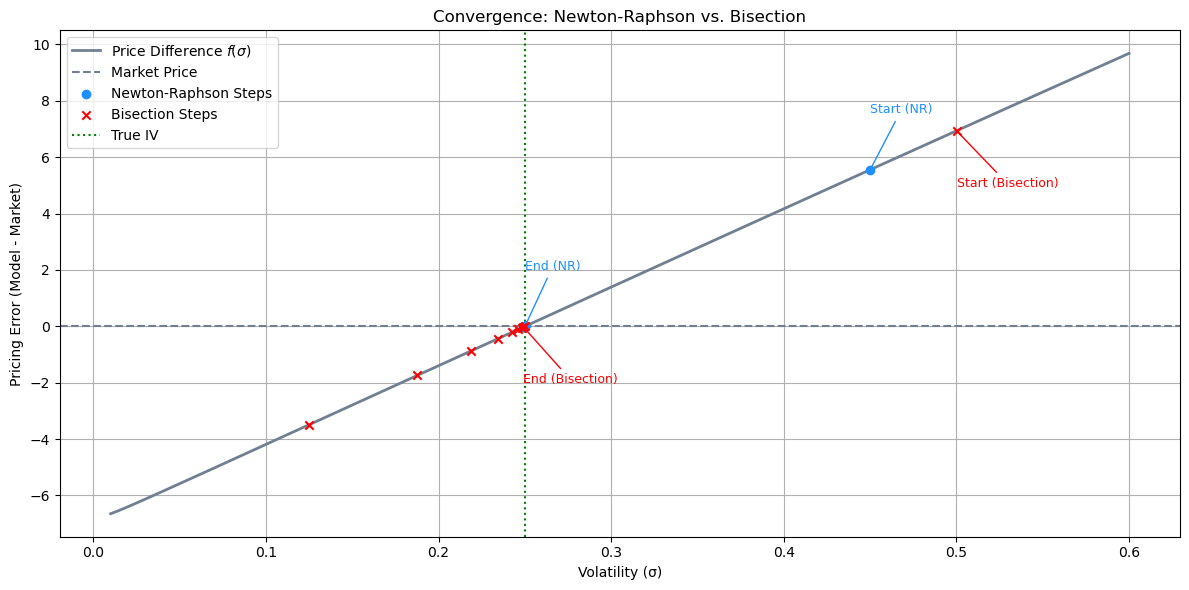

In [447]:
### Comparing convergence of Newton-Raphson with bisection

import numpy as np
from scipy.stats import norm

# Black-Scholes Call Price formula as discussed
def bs_price(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Vega as defined/derived through Black-Scholes formula
def vega(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    return S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

# Example option parameters for visualization purposes
S, K, T, r, q = 100, 100, 0.5, 0.01, 0.02
true_iv = 0.25
market_price = bs_price(S, K, T, r, q, true_iv)

# Function: pricing error vs sigma
def price_diff(sigma):
    return bs_price(S, K, T, r, q, sigma) - market_price

# Newton-Raphson steps
nr_sigma = 0.45  # Intentionally off to highlight convergence
nr_steps = [nr_sigma]
for _ in range(8):  # Number of steps is fixed for visualization. 
    price = bs_price(S, K, T, r, q, nr_sigma)
    v = vega(S, K, T, r, q, nr_sigma)
    if v == 0:
        break
    nr_sigma = nr_sigma - (price - market_price) / v
    nr_steps.append(nr_sigma)  # Collects stepping points for later plotting

# Bisection steps
low, high = 0.0001, 1.0
bisection_steps = []
for _ in range(10):  # Number of steps is fixed for visualization.
    mid = (low + high) / 2
    bisection_steps.append(mid)  # Collects stepping points for later plotting
    if price_diff(mid) > 0:
        high = mid
    else:
        low = mid

# Plot the function
sigma_range = np.linspace(0.01, 0.6, 500)
errors = [price_diff(s) for s in sigma_range]

plt.figure(figsize=(12, 6))
plt.plot(sigma_range, errors, label='Price Difference $f(\\sigma)$', lw=2, color='slategray')
plt.axhline(0, color='slategray', linestyle='--', label='Market Price')

# Newton-Raphson
nr_y = [price_diff(s) for s in nr_steps]
plt.scatter(nr_steps, nr_y, color='dodgerblue', marker='o', label='Newton-Raphson Steps', zorder=5)

plt.annotate("Start (NR)", xy=(nr_steps[0], nr_y[0]), 
             xytext=(nr_steps[0], nr_y[0] + 2),
             arrowprops=dict(arrowstyle="-", color='dodgerblue', lw=1),
             fontsize=9, color='dodgerblue')

plt.annotate("End (NR)", xy=(nr_steps[-1], nr_y[-1]), 
             xytext=(nr_steps[-1], nr_y[-1] + 2),
             arrowprops=dict(arrowstyle="-", color='dodgerblue', lw=1),
             fontsize=9, color='dodgerblue')

# Bisection
bis_y = [price_diff(s) for s in bisection_steps]
plt.scatter(bisection_steps, bis_y, color='red', marker='x', label='Bisection Steps', zorder=5)

plt.annotate("Start (Bisection)", xy=(bisection_steps[0], bis_y[0]),
             xytext=(bisection_steps[0], bis_y[0] - 2),
             arrowprops=dict(arrowstyle="-", color='red', lw=1),
             fontsize=9, color='red')

plt.annotate("End (Bisection)", xy=(bisection_steps[-1], bis_y[-1]),
             xytext=(bisection_steps[-1], bis_y[-1] - 2),
             arrowprops=dict(arrowstyle="-", color='red', lw=1),
             fontsize=9, color='red')

# Highlight the true IV
plt.axvline(true_iv, color='green', linestyle=':', label='True IV')

# Labels and formatting
plt.xlabel('Volatility (σ)')
plt.ylabel('Pricing Error (Model - Market)')
plt.title('Convergence: Newton-Raphson vs. Bisection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Considerations Regarding Speed and Stability

With our approach, implied volatility (IV) must be estimated numerically for each individual contract. In a dataset like ours, with over 250,000 contracts, this requires solving a nonlinear equation hundreds of thousands of times.

A single loop over the dataset might seem acceptable in isolation, but our loop includes many expensive operations:
- Pre-checking intrinsic value  
  - Recall that if the market price is below the intrinsic value of the contract, no IV exists that satisfies the no-arbitrage constraint of the Black-Scholes model. Both Newton-Raphson and bisection would fail to compute a valid solution.
- Computing components like $\ln\left(\frac{S}{K}\right)$, $\sqrt{T}$, $d_1$, and Vega
- Executing root-finding algorithms, which are themselves iterative

If we were to calculate all these quantities row-by-row, the total time would compound quickly. By __vectorizing all precomputable inputs__, we let NumPy run them in optimized C-based code — often __10×–50× faster__ than native Python loops.

This matters not just for speed, but also for __stability__:
- Filtering out invalid options early (e.g., negative time to maturity or inconsistent prices) prevents numerical failures
- Precomputing robust inputs (such as Vega at a reasonable σ guess) improves the convergence reliability of our IV solver

In the next cell, we show a realistic benchmark comparing a loop-based vs. vectorized version of such precomputations as they would occur in our actual computations.

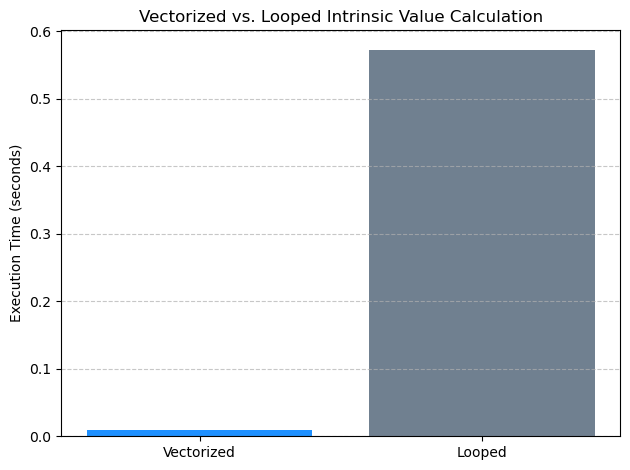

Speedup: 62.96x faster using vectorization


In [954]:
### Benchmark comparing loop-based vs. vectorized calculation of intrinsic value

import time

# Sample data (simulate structure of df_analysis, which is the real data)
N = 250000 # similar size to our data
np.random.seed(42) # random seed
df_sim = pd.DataFrame({ 
    'underlying_last': np.random.uniform(90, 110, N), # random underlying prices between 90, 110
    'strike': np.random.uniform(90, 110, N), # random strikes between 90, 110
    'is_call': np.random.choice([True, False], N) # random contract type 
})

# Vectorized version
start_vec = time.perf_counter() # Timer

# Vector calculation of intrinsic value for all simulated contracts
intrinsic_vectorized = np.where(
    df_sim['is_call'],
    np.maximum(df_sim['underlying_last'] - df_sim['strike'], 0), 
    np.maximum(df_sim['strike'] - df_sim['underlying_last'], 0)
)

end_vec = time.perf_counter()
time_vec = end_vec - start_vec

# Loop version
start_loop = time.perf_counter() # Timer

# Loop over all contracts, test contract type, apply correct formula individually
intrinsic_loop = []
for row in df_analysis.itertuples():
    if row.is_call:
        val = max(row.underlying_last - row.strike, 0)
    else:
        val = max(row.strike - row.underlying_last, 0)
    intrinsic_loop.append(val) # Append intrinsic value to list

end_loop = time.perf_counter()
time_loop = end_loop - start_loop

# Plotting
plt.bar(['Vectorized', 'Looped'], [time_vec, time_loop], color=['dodgerblue', 'slategray'])
plt.ylabel("Execution Time (seconds)")
plt.title("Vectorized vs. Looped Intrinsic Value Calculation")
plt.grid(axis='y')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Speedup factor
print(f"Speedup: {time_loop / time_vec:.2f}x faster using vectorization")


__The benefits are additative for each vectorized operation__, we therefore want to maximize the amount of vectorized precomputation.

## 8. Practical Implementation

For the actual computation of IV for each individual contract, we break the process up into __three parts:__
- __Prechecking intrinsic value__ and other parameters that could disqualify the contract
- __Precomputing inputs in a vectorized manner__: this includes $\ln\left(\frac{S}{K}\right)$, $\sqrt{T}$, $d_1$, and Vega
- __Calculating IV with root finding algorithms__, should Newton-Raphson fail, fall back to bisection

### 8.1 Prechecking

In [491]:
### Filtering invalid contracts before IV calculation, with detailed counts

# Required columns
S = df_analysis['underlying_last']
K = df_analysis['strike']
T = df_analysis['time_to_maturity']
mid = df_analysis['mid_price']
is_call = df_analysis['is_call']

# Intrinsic value: max(S - K, 0) for calls, max(K - S, 0) for puts
intrinsic = np.where(is_call, np.maximum(S - K, 0), np.maximum(K - S, 0))

# Build individual rule masks
invalid_T       = T <= 0
invalid_price   = mid <= 0
invalid_S       = S <= 0
invalid_K       = K <= 0
invalid_intr    = mid < intrinsic

# Combine into a single validity mask
valid_mask = ~(invalid_T | invalid_price | invalid_S | invalid_K | invalid_intr)

# Final filtered dataset
df_filtered = df_analysis[valid_mask].copy()

# Count invalids by reason (excluding overlaps)
n_invalid_T       = invalid_T.sum()
n_invalid_price   = (~invalid_T & invalid_price).sum()
n_invalid_S       = (~invalid_T & ~invalid_price & invalid_S).sum()
n_invalid_K       = (~invalid_T & ~invalid_price & ~invalid_S & invalid_K).sum()
n_invalid_intr    = (~invalid_T & ~invalid_price & ~invalid_S & ~invalid_K & invalid_intr).sum()

# Output
print(f"Total contracts: {len(df_analysis)}")
print(f"Remaining after filtering: {len(df_filtered)}")
print("Disqualified due to:")
print(f" - Time to maturity ≤ 0:        {n_invalid_T}")
print(f" - Mid price ≤ 0:               {n_invalid_price}")
print(f" - Underlying price ≤ 0:        {n_invalid_S}")
print(f" - Strike price ≤ 0:            {n_invalid_K}")
print(f" - Mid price < intrinsic:    {n_invalid_intr}")


Total contracts: 256218
Remaining after filtering: 205697
Disqualified due to:
 - Time to maturity ≤ 0:        0
 - Mid price ≤ 0:               0
 - Underlying price ≤ 0:        0
 - Strike price ≤ 0:            0
 - Mid price < intrinsic:    50521


We are dropping a total of 50,521 contracts for which the midpoint price is below intrinsic value.  
This violates the fundamental no-arbitrage bounds implied by the [Black-Scholes framework](https://www.columbia.edu/~mh2078/FoundationsFE/BlackScholes.pdf), as an option’s price must be at least as large as its intrinsic value.

Such violations may arise from stale quotes, poor bid-ask midpoint estimates (especially for illiquid or deep in-the-money contracts), or rounding errors in end-of-day pricing. Since the Black-Scholes model is strictly monotonic in volatility and bounded below by intrinsic value, no implied volatility can rationalize such prices — both Newton-Raphson and bisection methods would fail to converge or produce spurious solutions.

This also raises a broader modeling consideration: whether the __midpoint price__ is always the best proxy for the true market value, particularly in the presence of wide spreads. That said, the fact that all other disqualification categories (e.g., zero prices or time to maturity) return zero counts speaks to the overall quality and consistency of the dataset and its preparation process.


### 8.2 Precomputation

#### Note on the Initial Volatility Guess for Vega

Although we estimate implied volatility (IV) in a later step, we already supply an initial guess for volatility in this precomputation cell. The reason is that __Vega__, which is required by the Newton-Raphson method, depends on the value of $d_1$, and $d_1$ itself depends directly on volatility $\sigma$.

Recall:
$$
d_1 = \frac{\ln(S/K) + \left(r - q + \frac{1}{2} \sigma^2\right)T}{\sigma \sqrt{T}}
$$

This means that to compute __Vega__ (which we precompute here to identify options where Newton-Raphson may become unstable), we must already supply some volatility value.
We can summarize the dependency chain as:

$$
\sigma_{\text{guess}} \quad \xrightarrow{\text{used in}} \quad d_1 \quad \xrightarrow{\text{used in}} \quad \text{Vega} \quad \xrightarrow{\text{used in}} \quad \text{Newton-Raphson update for } \sigma
$$

Hence, we use a __fixed initial guess__ — typically $\sigma = 0.2$ — to evaluate Vega for all options. This guess is not used to estimate the final implied volatility; it's only used to get a rough idea of how sensitive the option price is to volatility at a reasonable starting point. The actual estimation of IV, including refined σ updates, will be performed in the final step.

We also use this precomputation step to flag contracts where Vega is too small for Newton-Raphson to be stable (Vega $< 1e\text{-}8$). These contracts are marked to use the bisection method immediately. This allows us to skip time-intensive Newton-Raphson iterations that have no chance of converging.

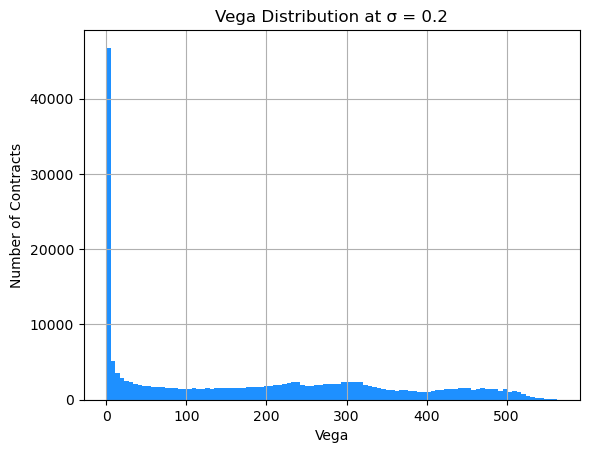

Precomputation complete.
10456 contracts flagged for bisection due to low Vega.


In [504]:
### Vectorized precomputation of inputs

# Extract filtered columns as NumPy arrays
S        = df_filtered['underlying_last'].to_numpy()
K        = df_filtered['strike'].to_numpy()
T        = df_filtered['time_to_maturity'].to_numpy()
r        = df_filtered['risk_free_rate'].to_numpy()
q        = df_filtered['Annualized_Dividend_Yield'].to_numpy()
is_call  = df_filtered['is_call'].to_numpy()
mid      = df_filtered['mid_price'].to_numpy()

# Initial guess for implied volatility used for Vega precheck
sigma_guess = 0.2

# Precompute Black-Scholes quantities at initial guess
log_SK   = np.log(S / K)
sqrt_T   = np.sqrt(T)
d1_guess = (log_SK + (r - q + 0.5 * sigma_guess**2) * T) / (sigma_guess * sqrt_T)
vega_guess = S * np.exp(-q * T) * norm.pdf(d1_guess) * sqrt_T

#Vega distribution to validate scale
plt.hist(vega_guess, bins=100, color='dodgerblue')
plt.title("Vega Distribution at σ = 0.2")
plt.ylabel("Number of Contracts")
plt.xlabel("Vega")
plt.grid(True)
plt.show()

# When Vega is too small, Newton-Raphson is unstable
vega_threshold = 1e-8  # Critical threshold below which NR should not be used
use_bisection = vega_guess < vega_threshold  # Boolean

# Store results in DataFrame
df_filtered['log_SK']       = log_SK
df_filtered['sqrt_T']       = sqrt_T
df_filtered['vega_guess']   = vega_guess
df_filtered['d1_guess']     = d1_guess
df_filtered['sigma_guess']  = sigma_guess  # Reference only
df_filtered['use_bisection'] = use_bisection

print("Precomputation complete.")
print(f"{use_bisection.sum()} contracts flagged for bisection due to low Vega.")


Let us briefly recall what __Vega__ represents:  
Vega measures the __sensitivity of an option’s price to changes in implied volatility__. Specifically, it quantifies the change in the option's theoretical value for a 1% (0.01) change in volatility:
$$
\text{Vega} = \frac{\partial \text{Option Price}}{\partial \sigma}
$$

This means that for a small change in implied volatility $\Delta\sigma$, the approximate change in the option price is given by:
$$
\Delta \text{Price} \approx \text{Vega} \times \Delta \sigma
$$

For example, if Vega is 150 and implied volatility increases by 1 percentage point (i.e., $\Delta\sigma = 0.01$), the option price increases by approximately \$1.50.

In our case, since all options are filtered to have approximately __30 days to expiration__, differences in Vega are primarily driven by __moneyness__ rather than time. Options that are __near the money__ tend to have the highest Vega, as their value is most sensitive to changes in volatility. In contrast, options that are __deep in-the-money__ or __far out-of-the-money__ have low Vega, since their price is dominated by intrinsic value or low likelihood of expiring in the money.

The distribution above reflects this structure: a large number of contracts have low Vega due to being far from the money, while those clustered around the strike level show higher sensitivity to volatility — as expected.

### 8.3 Calculating Implied Volatility

The final computational step uses the precomputed values to calculate the IV for all valid individual option contracts. As discussed, we implement a hybrid solver that:

- __First attempts__ to recover IV using the __Newton-Raphson method__, which is fast and converges quickly when the initial guess is close and the function is well-behaved.
- __Falls back__ to the more robust but slower __bisection method__ whenever:
  - The option’s Vega is too small (i.e., near-zero sensitivity to volatility changes), or
  - Newton-Raphson fails to converge within the specified tolerance and iteration limit.

This approach ensures both speed and stability. Each contract is solved independently, and the method used (`'newton'`, `'bisection'`, or `'failed'`) is tracked for diagnostic purposes.

The resulting implied volatilities are stored in a new DataFrame (`df_iv_results`) alongside the original option data, along with a summary of method usage and convergence outcomes.


In [847]:
### Calculates Implied Volatility for all valid individual options using scipy.stats (about 2 minutes, does not need to be run)

### Notable is that somewhere the scaling of IV got messed up. Iv is to low by a factor 10. This is adjusted for manually

import numpy as np
from scipy.stats import norm

# Black-Scholes Pricing and Vega formulas
def bs_price(S, K, T, r, q, sigma, is_call):
    """
    Returns the Black-Scholes price of a European call or put option.

    Parameters:
    - S: Underlying asset price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free rate
    - q: Continuous dividend yield
    - sigma: Volatility of the underlying
    - is_call: Boolean (True for call, False for put)
    """
    if T <= 0 or sigma <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if is_call:
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def vega(S, K, T, r, q, sigma):
    """
    Returns the Vega of a European option, i.e., the sensitivity of the price
    to changes in implied volatility.
    """
    if T <= 0 or sigma <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

# Implied Volatility: Newton-Raphson with Bisection fallback

def implied_volatility(price, S, K, T, r, q, is_call,
                       use_bisection=False, sigma_init=0.2,
                       tol=1e-6, max_iter=100):
    """
    Computes the implied volatility for a European option by solving:
        Black-Scholes price = observed market price
    - Attempts Newton-Raphson if not flagged
    - Falls back to bisection if NR fails or if Vega becomes too small
    - Returns (implied_vol, method_code) where method_code is:
        0 for Newton-Raphson
        1 for bisection
       -1 for failed to converge
    """
    # If flagged, use bisection only
    if use_bisection:
        low, high = 1e-6, 5.0
        for _ in range(max_iter):
            mid = (low + high) / 2
            mid_price = bs_price(S, K, T, r, q, mid, is_call)
            if abs(mid_price - price) < tol:
                return mid, 1
            if mid_price > price:
                high = mid
            else:
                low = mid
        return np.nan, -1  # did not converge

    # Try Newton-Raphson first
    sigma = sigma_init
    for _ in range(max_iter):
        price_est = bs_price(S, K, T, r, q, sigma, is_call)
        v = vega(S, K, T, r, q, sigma)
        if v < 1e-8:
            break  # Vega too small → unstable update
        step = (price_est - price) / v
        sigma -= step
        if abs(step) < tol:
            return sigma, 0  # NR success

    # Fallback to bisection if NR fails
    low, high = 1e-6, 5.0
    for _ in range(max_iter):
        mid = (low + high) / 2
        mid_price = bs_price(S, K, T, r, q, mid, is_call)
        if abs(mid_price - price) < tol:
            return mid, 1
        if mid_price > price:
            high = mid
        else:
            low = mid
    return np.nan, -1  # fallback also failed

# Apply to All Options (print update every 20%)

iv_list = []       # stores final implied volatility
method_list = []   # stores method used: 0 = NR, 1 = bisect, -1 = failed

n_total = len(df_filtered)
step = max(int(0.20 * n_total), 1)  # print update every 20%

print("Starting implied volatility estimation...")

start_time = time.perf_counter()

for i, row in enumerate(df_filtered.itertuples(index=False)):
    iv, method_code = implied_volatility(
        price=row.mid_price,
        S=row.underlying_last,
        K=row.strike,
        T=row.time_to_maturity,
        r=row.risk_free_rate,
        q=row.Annualized_Dividend_Yield,
        is_call=row.is_call,
        use_bisection=row.use_bisection
    )
    iv_list.append(iv)
    method_list.append(method_code)

    if i % step == 0 and i > 0:
        print(f" {100 * i / n_total:.0f}% complete ({i:,} of {n_total:,} contracts)")

end_time = time.perf_counter()
runtime = end_time - start_time

# Store results

# Adjustment for scaling mistake
iv_list = [iv * 10 if not np.isnan(iv) else np.nan for iv in iv_list] 

df_iv_results_scipy = df_filtered.copy()
df_iv_results_scipy['implied_volatility'] = iv_list
df_iv_results_scipy['method_used'] = [ {0: 'newton', 1: 'bisection', -1: 'failed'}[m] for m in method_list ]

# Summary

n_failed = df_iv_results_scipy['implied_volatility'].isna().sum()
n_newton = (df_iv_results_scipy['method_used'] == 'newton').sum()
n_bisect = (df_iv_results_scipy['method_used'] == 'bisection').sum()

print("\nIV estimation complete.")
print(f" - Total contracts:             {n_total:,}")
print(f" - Newton-Raphson:              {n_newton:,}")
print(f" - Bisection fallback:          {n_bisect:,}")
print(f" - Failed to converge (NaNs):   {n_failed:,}")
print(f"\n Runtime: {runtime:.2f} seconds")


Starting implied volatility estimation...
 20% complete (41,139 of 205,697 contracts)
 40% complete (82,278 of 205,697 contracts)
 60% complete (123,417 of 205,697 contracts)
 80% complete (164,556 of 205,697 contracts)
 100% complete (205,695 of 205,697 contracts)

IV estimation complete.
 - Total contracts:             205,697
 - Newton-Raphson:              166,253
 - Bisection fallback:          36,963
 - Failed to converge (NaNs):   2,481

 Runtime: 123.19 seconds


#### One Change for about 40x Speed

To compute Black-Scholes option prices and Vega, we require the standard normal cumulative distribution function (CDF) and probability density function (PDF). 

While `scipy.stats.norm.cdf()` and `norm.pdf()` are accurate and convenient, they are part of a __general-purpose statistical library__. This introduced significant overhead operations, which results in a noticable bottleneck.

In our use case, we are calling these functions __hundreds of thousands of times__ with simple scalar inputs. This allows us to instead of

For example, the standard normal CDF has a well-known equivalence:
$$
\Phi(x) = \frac{1}{2} \left( 1 + \text{erf}\left( \frac{x}{\sqrt{2}} \right) \right)
$$
This form is fast to evaluate using Python's `math.erf()` function, and similar for the PDF:
$$
\phi(x) = \frac{1}{\sqrt{2\pi}} e^{-0.5 x^2}
$$

[_Helpful walktrough_](https://stats.stackexchange.com/questions/187828/how-are-the-error-function-and-standard-normal-distribution-function-related)

These scalar expressions avoid unnecessary overhead and are **functionally identical** for our purposes. They are particularly effective in scalar-valued loops, where `scipy`'s added flexibility becomes unnecessary.

In [863]:
### Calculates Implied Volatility for all valid individual options using custom norm_cdf and norm_pdf 

### Notable is that somewhere along the lines the scale of the IV calculation got messed up and is to low by a factor 10. For now this is adjusted for manually, the point is documented

import numpy as np
from math import erf, exp, sqrt, pi

# Normal distribution functions (fast scalar approximation)
def norm_cdf(x):
    """
    Standard normal cumulative distribution function.
    Implemented using the error function (erf), which is mathematically equivalent.
    """
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def norm_pdf(x):
    """
    Standard normal probability density function.
    Direct formula based on exponential function.
    """
    return (1.0 / sqrt(2.0 * pi)) * exp(-0.5 * x * x)

# Black-Scholes Pricing and Vega formulas
def bs_price(S, K, T, r, q, sigma, is_call):
    if T <= 0 or sigma <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    if is_call:
        return S * exp(-q * T) * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2)
    else:
        return K * exp(-r * T) * norm_cdf(-d2) - S * exp(-q * T) * norm_cdf(-d1)

def vega(S, K, T, r, q, sigma):
    if T <= 0 or sigma <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    return S * exp(-q * T) * norm_pdf(d1) * sqrt(T)


# Implied Volatility Solver (Newton-Raphson with Bisection fallback)
def implied_volatility(price, S, K, T, r, q, is_call,
                       use_bisection=False, sigma_init=0.2,
                       tol=1e-6, max_iter=100):

    if use_bisection:
        low, high = 1e-6, 5.0
        for _ in range(max_iter):
            mid = (low + high) / 2
            mid_price = bs_price(S, K, T, r, q, mid, is_call)
            if abs(mid_price - price) < tol:
                return mid, 1
            if mid_price > price:
                high = mid
            else:
                low = mid
        return np.nan, -1

    sigma = sigma_init
    for _ in range(max_iter):
        price_est = bs_price(S, K, T, r, q, sigma, is_call)
        v = vega(S, K, T, r, q, sigma)
        if v < 1e-8:
            break
        step = (price_est - price) / v
        sigma -= step
        if abs(step) < tol:
            return sigma, 0

    # Fallback to bisection
    low, high = 1e-6, 5.0
    for _ in range(max_iter):
        mid = (low + high) / 2
        mid_price = bs_price(S, K, T, r, q, mid, is_call)
        if abs(mid_price - price) < tol:
            return mid, 1
        if mid_price > price:
            high = mid
        else:
            low = mid
    return np.nan, -1

# Apply to All Options
iv_list = []
method_list = []

n_total = len(df_filtered)
step = max(int(0.20 * n_total), 1)

print("Starting implied volatility estimation...")

start_time = time.perf_counter()

for i, row in enumerate(df_filtered.itertuples(index=False)):
    iv, method_code = implied_volatility(
        price=row.mid_price,
        S=row.underlying_last,
        K=row.strike,
        T=row.time_to_maturity,
        r=row.risk_free_rate,
        q=row.Annualized_Dividend_Yield,
        is_call=row.is_call,
        use_bisection=row.use_bisection
    )
    iv_list.append(iv)
    method_list.append(method_code)

end_time = time.perf_counter()
runtime = end_time - start_time

# This is the manual adjustment for the scale
iv_list = [iv * 10 if not np.isnan(iv) else np.nan for iv in iv_list]

# Store results and show summary
df_iv_results_erf = df_filtered.copy()
df_iv_results_erf['implied_volatility'] = iv_list
df_iv_results_erf['method_used'] = [ {0: 'newton', 1: 'bisection', -1: 'failed'}[m] for m in method_list ]

n_failed = df_iv_results_erf['implied_volatility'].isna().sum()
n_newton = (df_iv_results_erf['method_used'] == 'newton').sum()
n_bisect = (df_iv_results_erf['method_used'] == 'bisection').sum()

print("\nIV estimation complete.")
print(f" - Total contracts:             {n_total:,}")
print(f" - Newton-Raphson:              {n_newton:,}")
print(f" - Bisection fallback:          {n_bisect:,}")
print(f" - Failed to converge (NaNs):   {n_failed:,}")
print(f"\n Runtime: {runtime:.2f} seconds")


Starting implied volatility estimation...

IV estimation complete.
 - Total contracts:             205,697
 - Newton-Raphson:              166,253
 - Bisection fallback:          36,963
 - Failed to converge (NaNs):   2,481

 Runtime: 3.08 seconds



## 9. Analysis: Investigating the Compression of the Volatility Risk Premium

With IV estimates now available for a panel of SPX option contracts, we turn to the core objective of this notebook: examining whether the volatility risk premium (VRP) has undergone structural compression over time.

The volatility risk premium is typically defined as:
$$
\text{VRP} = \text{IV} - \text{RV}
$$

Where:
- __IV__ is the risk-neutral expectation of volatility (implied from option prices)
- __RV__ is the actual realized volatility over the remaining life of the option, measured ex post

A positive VRP reflects the fact that options — particularly index options — tend to be priced above expected realized volatility, reflecting compensation for bearing tail risk and jump uncertainty. However, if this premium has been systematically harvested (e.g., through short volatility strategies, structured products, or institutional selling), we might expect the VRP to shrink or “compress” over time.

Our goal is to:
- Calculate and align realized volatility with each contract's forward-looking horizon
- Construct the time series of VRP across the sample
- Explore trends, shifts, or clustering in the VRP over time
- Investigate whether VRP compression can be empirically observed

We begin by estimating realized volatility over each contract’s horizon.

### 9.1 Realized Volatility

To align with the theoretical assumptions of the Black-Scholes model, we compute realized volatility using **log returns** rather than arithmetic returns.

Log returns are defined as:
$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

They are consistent with the __lognormal price assumption__ underlying IV in the Black-Scholes model. For this reason, using log returns is standard practice when estimating realized volatility.

The realized volatility during each contract is calculated as:
$$
\text{RV} = \text{Std}(r_t) \times \sqrt{252}
$$

Where:
- $r_t$ are daily log returns starting from the contract’s quote date
- The window length is determined by the contract's DTE (days to expiration)
    - We use 21-day windows for all our contracts. This is because DTE does not exlude non-trading days, and there are usually 21 trading days in a commomn 30 day window
- The result is annualized to match the scale of implied volatility

All necessary Inputs to compute realized volatility matching the option contracts horizons are already loaded in the dataframe `df_merged`.

In [865]:
### Calculating realized volatility, building the dataframe for further analysis

# Sort and calculate log returns from SP500_Close
df_merged = df_merged.sort_values('quote_date').copy()
df_merged['log_return'] = np.log(df_merged['SP500_Close'] / df_merged['SP500_Close'].shift(1))

# Extract unique quote_dates from options data
quote_dates = df_iv_results_erf['quote_date'].drop_duplicates().sort_values().reset_index(drop=True)

# Prepare SPX log return series
returns = df_merged[['quote_date', 'log_return']].dropna().reset_index(drop=True)

# Calculate 21-day forward-looking realized volatility per quote_date
rv_lookup = {}
print("Calculating 21-day realized volatility per quote_date...")

for i in range(len(returns)):
    qdate = returns.loc[i, 'quote_date']
    if i + 21 >= len(returns):
        break
    forward_returns = returns.loc[i+1:i+21, 'log_return']
    std = np.std(forward_returns)
    rv = std * np.sqrt(252) * 100  # annualized in %
    rv_lookup[qdate] = rv

# Map RV back to options panel
df_iv_results_erf['realized_volatility_21d'] = df_iv_results_erf['quote_date'].map(rv_lookup)

# Build final df_vrp with full structure
df_vrp = df_iv_results_erf[[
    'quote_date',              # when the option was observed
    'expire_date',             # when the option expires
    'strike',                  # strike price
    'is_call',                 # True = call, False = put
    'underlying_last',         # SPX spot price at quote date
    'mid_price',               # midpoint between bid/ask
    'implied_volatility',      # IV (in %)
    'realized_volatility_21d', # RV (in %, 21-day forward window)
    'method_used'              # IV solver method
]].copy()

# Summary
n_matched = df_vrp['realized_volatility_21d'].notna().sum()
print(f"✓ df_vrp constructed with {n_matched:,} matched quote_dates.")


Calculating 21-day realized volatility per quote_date...
✓ df_vrp constructed with 205,697 matched quote_dates.



#### Why we drop some Contracts

While computing realized volatility (RV) for each contract, we encounter a subset of contracts for which the calculation is not possible due to insufficient return data. These contracts are excluded from further analysis.

This occurs for the following reason:

- For each contract, we estimate RV over its __forward time horizon__, starting the day after the `quote_date` and extending for the number of days to expiration (`dte`).
- This requires at least `dte` daily S&P500 return observations after the quote date.
- If the `quote_date` is too close to the end of our S&P 500 historical dataset (e.g., in late December 2023), then the required number of forward returns is not available.

As a result, contracts for which:
$$
\text{quote\_date} + \text{dte} > \text{last date in SPX return data}
$$
cannot be matched to a full window of observed returns, and are therefore assigned `NaN` for realized volatility, this presents as 0.0 in our final dataframe.

This can obviously be prevented with better preparation by adjusting the end of the S&P 500 returns data.

We also use this opportunity drop contracts where the Newton-Raphson method and the bisection both failed.

In [867]:
df_vrp.head(3)

,quote_date,expire_date,strike,is_call,underlying_last,mid_price,implied_volatility,realized_volatility_21d,method_used
0,2011-08-16,2011-09-15,100.0,False,1192.50,1089.795,NaN,15.441218,failed
1,2012-01-17,2012-02-16,100.0,False,1293.56,1190.550,NaN,10.016423,failed
2,2013-02-12,2013-03-14,100.0,False,1519.59,1415.140,NaN,2.117182,failed


In [869]:
df_vrp.tail(3)

,quote_date,expire_date,strike,is_call,underlying_last,mid_price,implied_volatility,realized_volatility_21d,method_used
256541,2022-05-18,2022-06-17,7200.0,False,3925.31,3280.40,10.986559,1.981038,bisection
256553,2022-05-18,2022-06-17,7300.0,False,3925.31,3380.30,11.197697,1.981038,bisection
256566,2022-04-22,2022-05-20,7600.0,False,4272.45,3332.65,10.713010,1.920787,bisection


In [871]:
### Drop rows with RV = 0 or failed IV computation
df_vrp_clean = df_vrp[
    (df_vrp['realized_volatility_21d'] != 0) &
    (df_vrp['method_used'] != 'failed')
].copy()

print(f"Remaining contracts: {len(df_vrp_clean):,}")


Remaining contracts: 202,734



### 9.2 Aggregating Implied Volatility

After calculating realized volatility, we are almost ready to investigate the suspected compression of the volatility risk premium (VRP). However, because implied volatility (IV) is computed at the level of individual option contracts, we must first define a robust method for aggregation.

Averaging IV across contracts is not trivial. Implied volatility is not directly additive and can be influenced by option moneyness, maturity, and liquidity. To ensure comparability with realized volatility — which we computed over a forward 21-day window — we restrict our aggregation to options with approximately 30 days to expiration.

For each quote date, we compute the __midprice-weighted average implied volatility__ across all valid options. This ensures that contracts with higher market value contribute proportionally more to the daily IV estimate, reflecting economically significant positions while smoothing out noise from illiquid or extreme strikes.

The weighted average implied volatility is given by:

$$
\text{IV}_{\text{weighted}} = \frac{\sum_{i=1}^{n} \text{IV}_i \cdot w_i}{\sum_{i=1}^{n} w_i}, \quad \text{where } w_i = \text{mid\_price}_i
$$

This method is conceptually similar to the construction of the __CBOE VIX index__, which uses a weighted sum of S&P 500 index options across a range of strikes to estimate the market's 30-day forward variance. While our implementation is simpler and does not involve replication or interpolation, it shares the objective of capturing the market-implied volatility expectation over a fixed horizon.

The result is a time series of aggregated implied volatility estimates that can be directly compared to the subsequently realized volatility, allowing us to study the behavior and potential compression of the volatility risk premium.


In [894]:
### Weighted average IV, dataframe for plotting

# Define weighted average function
def weighted_avg_iv(group):
    return np.average(group['implied_volatility'], weights=group['mid_price'])

# Use .agg() with named function (safe and warning-free)
df_iv_weighted = (
    df_vrp_clean
    .groupby('quote_date')
    .agg(iv_weighted_avg=('implied_volatility', lambda x: weighted_avg_iv(df_vrp_clean.loc[x.index])))
    .reset_index()
)
# Realized volatility (already per quote_date)
df_rv_daily = (
    df_vrp_clean[['quote_date', 'realized_volatility_21d']]
    .drop_duplicates(subset='quote_date')
)

# Merge IV and RV
df_ivrv_daily = pd.merge(
    df_iv_weighted,
    df_rv_daily,
    on='quote_date',
    how='inner'
)
# Add vrp
df_ivrv_daily['vrp'] = df_ivrv_daily['iv_weighted_avg'] - df_ivrv_daily['realized_volatility_21d']

print(df_ivrv_daily.head(3))

  quote_date  iv_weighted_avg  realized_volatility_21d        vrp
0 2010-02-17        26.172802                 2.218752  23.954050
1 2010-02-18        22.352697                 2.725841  19.626857
2 2010-03-01         4.958770                 9.438038  -4.479268



### 9.3 The Volatility Risk Premium over Time

The charts below visualise the evolution of the relationship between IV and realized volatility.

#### Observations:

- __Structural Positivity of VRP:__  
  For the majority of the time series, IV exceeds RV, particularly in low-volatility environments. This reflects the ongoing market demand for protection and the embedded risk aversion in option pricing.

- __Crisis Period Exceptions:__  
  In extreme environments (e.g., during the 2011 debt ceiling crisis or the March 2020 COVID shock), RV briefly exceeds IV. These are instances where the market failed to anticipate tail risk, leading to a negative VRP.

- __Regime Shift Post-2012:__  
  Beginning around 2012, both IV and RV settle into a structurally lower range. While the VRP remains positive, its magnitude decreases. This supports the hypothesis that the volatility risk premium may have been systematically compressed over time — potentially due to the rise of volatility-selling products (e.g. short VIX ETPs) and increased competition among option sellers.

- __Compression is Visible, but Gradual:__  
  The smoothed VRP curve shows a slow decline in the premium captured by option sellers. Although not always monotonic, the long-run trend suggests that the opportunity to extract excess returns from selling volatility may have diminished as the strategy became increasingly crowded.


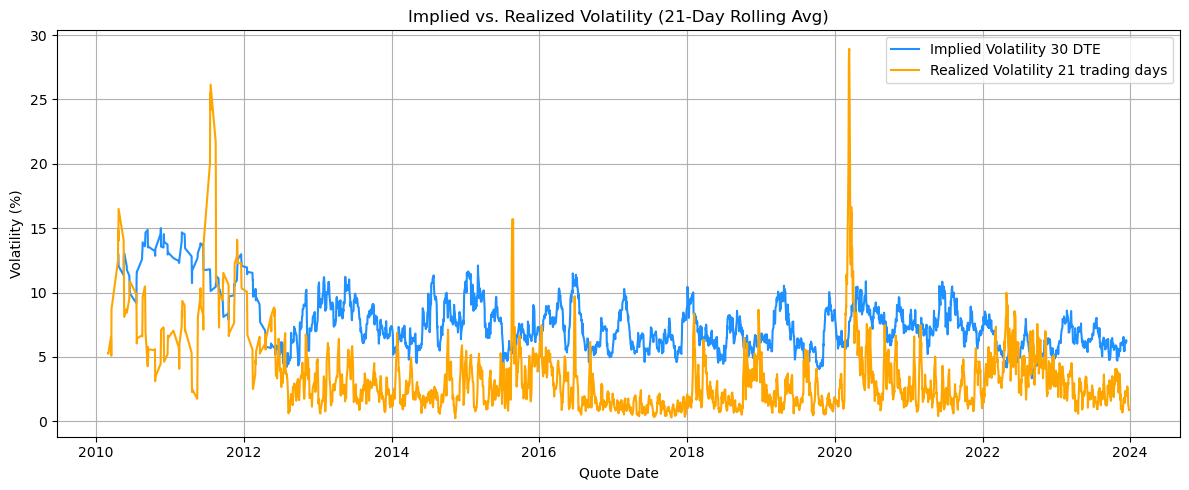

In [938]:
### Graph implied vs realized volatility


import matplotlib.pyplot as plt

# Apply rolling average for smoothing
df_ivrv_smooth = df_ivrv_daily.copy()
df_ivrv_smooth['iv_smooth'] = df_ivrv_smooth['iv_weighted_avg'].rolling(window=21, center=True).mean()
df_ivrv_smooth['rv_smooth'] = df_ivrv_smooth['realized_volatility_21d'].rolling(window=5, center=True).mean()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_ivrv_smooth['quote_date'], df_ivrv_smooth['iv_smooth'], label='Implied Volatility 30 DTE', color='dodgerblue')
plt.plot(df_ivrv_smooth['quote_date'], df_ivrv_smooth['rv_smooth'], label='Realized Volatility 21 trading days', color='orange')

# Styling
plt.title("Implied vs. Realized Volatility (21-Day Rolling Avg)")
plt.xlabel("Quote Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


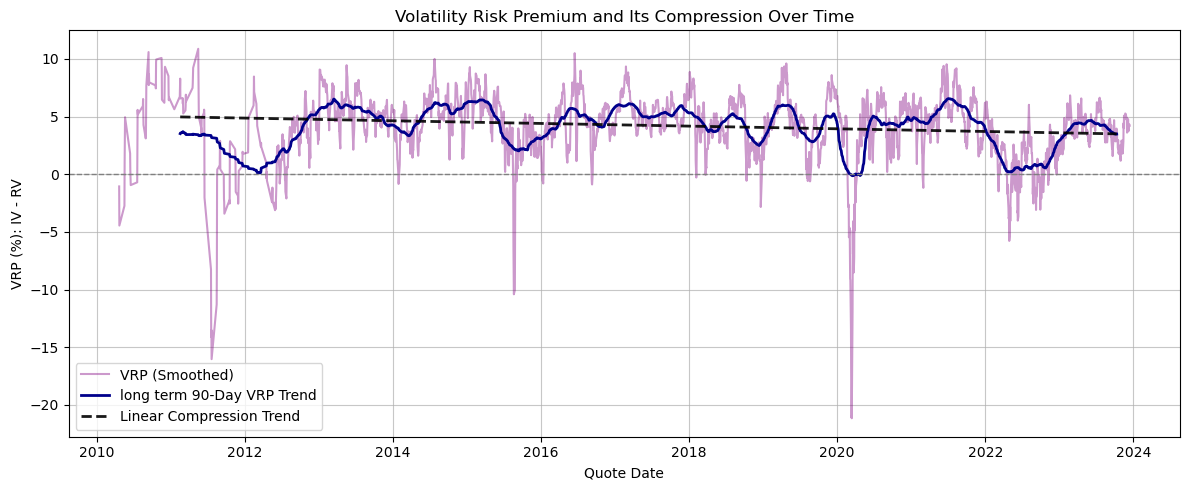

In [946]:
### Graph Volatility Risk Premium over time

from scipy.stats import linregress

# Compute long-term smoothed VRP trend
df_ivrv_smooth['vrp_smooth'] = df_ivrv_smooth['iv_smooth'] - df_ivrv_smooth['rv_smooth']
df_ivrv_smooth['vrp_trend'] = df_ivrv_smooth['vrp_smooth'].rolling(window=90, center=True).mean()

# Linear trend line fit
valid = df_ivrv_smooth[['quote_date', 'vrp_trend']].dropna()
x = valid['quote_date'].map(pd.Timestamp.toordinal)
slope, intercept, *_ = linregress(x, valid['vrp_trend'])

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_ivrv_smooth['quote_date'], df_ivrv_smooth['vrp_smooth'], label='VRP (Smoothed)', color='purple', alpha=0.4)
plt.plot(df_ivrv_smooth['quote_date'], df_ivrv_smooth['vrp_trend'], label='long term 90-Day VRP Trend', color='darkblue', linewidth=2)

# Add zero line
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Add linear trend line
plt.plot(valid['quote_date'], slope * x + intercept, color='black', linestyle='--', linewidth=2, alpha=0.9, label='Linear Compression Trend')

# Labels and styling
plt.title("Volatility Risk Premium and Its Compression Over Time")
plt.xlabel("Quote Date")
plt.ylabel("VRP (%): IV - RV")
plt.legend()
plt.grid(alpha=0.7)
plt.tight_layout()
plt.show()


## 9.4 The Volatility Risk Premium has Compressed — So What?

A compressed volatility risk premium motivates many questions for market participants. Just to name a few that come to mind:

- Has the systematic selling of volatility become so widespread that excess returns from short-vol strategies are largely arbitraged away?
- Is the compensation for bearing volatility risk still sufficient relative to the tail-risks incurred?
- Can we identify structural breaks or behavioral dynamics that explain when VRP is at risk of inverting?
- Does a compressed VRP imply improved market efficiency — or simply a more crowded trade with diminished payoff asymmetry?
- Should investors consider switching from short-vol to long-vol exposure in low-premium environments?

Answering a question often means generating a handful of new ones. I like to believe that I'm always two good questions away from truly understanding the answer to my last one.

I plan to return to some of these questions in the future, equipped with a stronger understanding, better technical skills and the same curiosity.

## 10. Acknowledging Mistakes

As of now, I am aware of two areas that can be improved:

- __Boundary drops due to incomplete data__ 
  I drop contracts at the beginning and end of the dataset due to missing values for the annualized dividend yield (early period) and missing realized volatility data (late period). These drops could be avoided by better preparing the input data at the dataset's temporal boundaries - annualized dividend yield and realized volatility is both easily accessable data 

- __Implied volatility scale offset__  
  My computed implied volatilities were off by a factor of 10. I corrected this via manual rescaling (multiplying the results by 10), but I have not yet identified the root cause. This deserves further investigation to ensure the model is internally consistent and well-calibrated


## 11. Reflection

I learned an unbelievable amount about basically every concept this notebook touches on while writing. Many of these things I have not been able to show, but I atleast want to mention setting up a remote accessiable database(thank you [Aiven](https://console.aiven.io/login), you made it so easy I almost forget about the multitude of failures I had before. Learning to work with a dataset so large that speed became a real concern when interacting with the database humbled me. Working on my first notebook has shown me the shallow waters of many deep seas I might have never had explored otherwise, a process that has been exciting and educating. I am grateful for all the fantastic learning ressources people provide and hope that I will be able to give some of that back one day.